# Spectrogram Time-Frequency Space Representation

As we saw in the previous section, the cursory 1-dimensional time and frequency domain representations do not faithfully capture the information contained in the signal. To represent the data with a higher degree of fidelity, let's start by considering the conventional spectrogram-based approach.

The process of generating a spectrogram requires splitting the signal into overlapping segments and applying the Fourier transform to these windows. This is called the short time Fourier transform (STFT).

The following plot presents a spectrogram representation of our orca call. We'll start off using the ``spectrogram`` method found in ``scipy.signal``.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import soundfile as sf
from IPython.display import Audio

from fastai2.vision.all import *

from scipy.signal import spectrogram

np.random.seed(42)

In [6]:
path_name = '/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff'
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

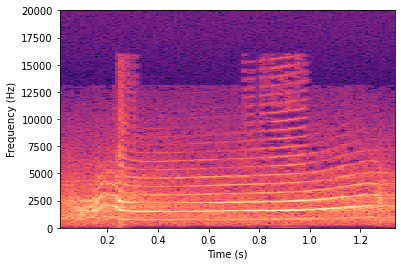

In [11]:
f_bins, t_bins, Sxx = spectrogram(signal_orca, fs=sr_orca,
                                 window='hanning', nperseg=1024,
                                 noverlap=1024-512, detrend=False,
                                 scaling='spectrum')
plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 2e4])
plt.show()

Awesome! We now have a time-frequency representation of our signal. Note that we take the log of ``Sxx`` to compress the spectrum to the dB scale. Also, we have added a threshold ``amin=1e-100`` to protect us from taking the log of zero. More on this later.

However, there are many parameters to consider when constructing spectrograms. To begin unpacking the numerous options, we start by considering the uncertainty principle, which tells us that there is a tradeoff between time resolution and frequency resolution, since we can't simultaneously minimize both. The parameter ``nperseg`` yields insights into these resolutions. 

Using ``nperseg=1024`` with a sample rate of 44.1 kHz leads to a window length (temporal resolution) of 

$$ \frac{1024}{44100} = 0.023 \text{s} $$

and a frequency resolution of 

$$ \frac{44100}{1024} = 43.1 \text{Hz}$$

This tells us that all else equal, increasing ``nperseg`` improves frequency resolution but impairs temporal resolution. This is demonstrated in the following plot.

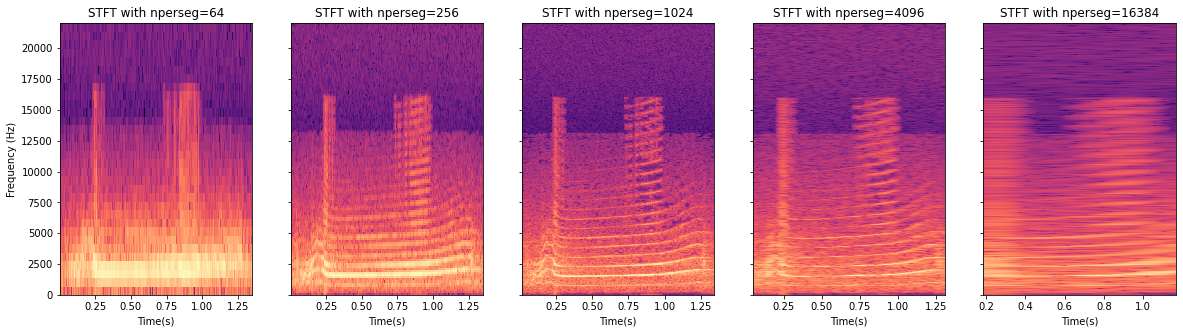

In [13]:
npersegs = [64, 256, 1024, 4096, 16384]
fig, axs = plt.subplots(1, len(npersegs), sharey=True, figsize=(20,5))
axs[0].set_ylabel('Frequency (Hz)')

for i, window_length in enumerate(npersegs):
    f_bins, t_bins, Sxx = spectrogram(signal_orca, fs=sr_orca,
                                 window='hanning', nperseg=window_length,
                                 noverlap=window_length-64, detrend=False,
                                 scaling='spectrum')
    axs[i].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    axs[i].set_xlabel('Time(s)')
    axs[i].set_title(f'STFT with nperseg={window_length}')

In general, it is a safe bet to use ``noverlap = nperseg // 2``, but this can depend on the choice of window. Now that we have a better understanding of the window length parameter used in generating spectrograms, let's proceed with the windowing function. Again, we have many options here. A great place to start is the Kaiser window, defined mathematically by

$$w(n) = I_0 \Bigg( \beta\sqrt{1-\frac{4n^2}{(M-1)^2}}\Bigg) / I_0(\beta) \hspace{2mm}\text{for} -\frac{M-1}{2} \leq n \leq \frac{M-1}{2}$$

In general, a safe choice for $\beta$ is 14, but the following approximations are also used:

* $\beta$=0: Recrangular
* $\beta$=5: Hamming
* $\beta$=6: Hann
* $\beta$=8.6: Blackman

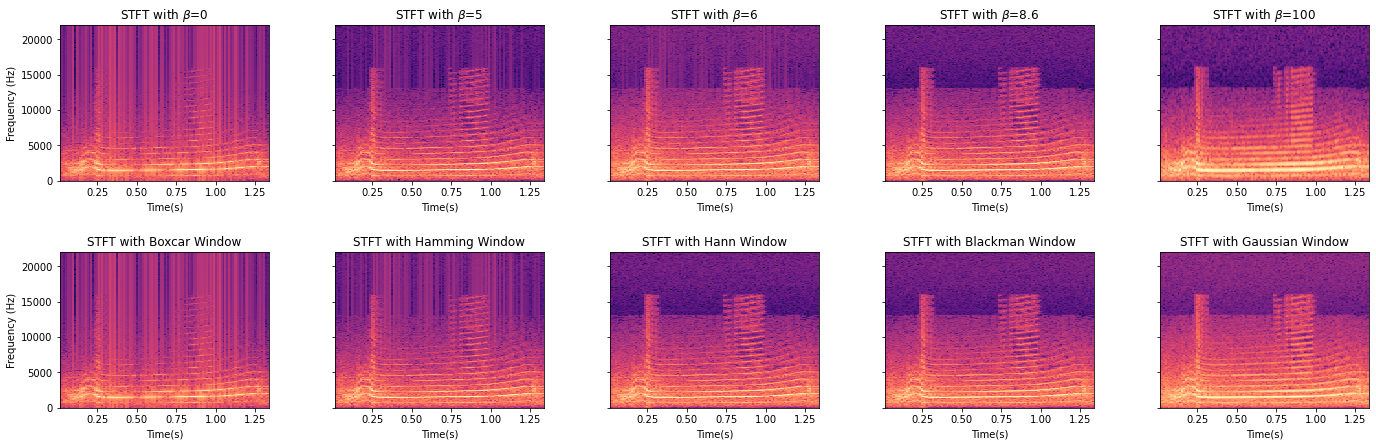

In [15]:
from scipy.signal import kaiser, gaussian
betas = [0, 5, 6, 8.6, 100]
win_g = gaussian(1024, 100)
wins = ['boxcar', 'hamming', 'hann', 'blackman', win_g]
fig, axs = plt.subplots(2, len(betas), sharey=True, figsize=(20,7))
fig.tight_layout(pad=5.0)
axs[0, 0].set_ylabel('Frequency (Hz)')
axs[1, 0].set_ylabel('Frequency (Hz)')
for i in range(2):
    if i == 0:
        for j, B in enumerate(betas):
            win = kaiser(1024, beta=B)
            f_bins, t_bins, Sxx = spectrogram(signal_orca, fs=sr_orca,
                                         window=win, nperseg=1024,
                                         noverlap=512, detrend=False,
                                         scaling='spectrum')
            axs[0,j].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
            axs[0,j].set_xlabel('Time(s)')
            axs[0,j].set_title(fr'STFT with $\beta$={B}')
    elif i ==1:
        for j, win in enumerate(wins):
            f_bins, t_bins, Sxx = spectrogram(signal_orca, fs=sr_orca,
                                         window=win, nperseg=1024,
                                         noverlap=512, detrend=False,
                                         scaling='spectrum')
            axs[1,j].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
            axs[1,j].set_xlabel('Time(s)')
            if j < 4:
                axs[1,j].set_title(f'STFT with {win.capitalize()} Window')
            elif j ==4:
                axs[1,j].set_title(f'STFT with Gaussian Window')  

We clearly see different behaviors depending on the choice of window. How do we make sense of this? A good resource to use can be accessed [here](https://www.ni.com/en-us/innovations/white-papers/06/understanding-ffts-and-windowing.html). 

You might be wondering why we need a window in the first place. In general, performing an FFT over a noninteger number of cycles can introduce spectral leakage due to artificial discontinuites present when segmenting the original signal into discrete windows. Applying a window reduces the amplitude of the discontinuities at the boundaries of each finite segment of the signal, minimizing the degree of spectral leakage.

Now that we understand the motivation for windowing, how do we choose an appropriate window for our given application?

## Choosing a Window

In general, the Fourier transform of a window yields a spectrum with a main lobe and side lobes of decaying amplitude. Lower side lobes typically minimize spectral leakage, but they also increase the bandwidth of the major lobe. The decay rate of the side lobe peaks is commonly referred to as the 'side lobe roll-off rate'.

With this in mind, selecting a window involves estimating the frequency content of the original signal. Important considerations include the distance (in frequency space) of strong interfering frequency components, the broadband/narrowband nature of a signal, and the desired amplitude accuracy of frequency components, among others.

A Hann window is often a satisfactoy choice for the majority of applications. There is no *a priori* approach to selecting a window from first principles, but the following can help you make an informed decision:

* Rectangular: transients with durations shorter than the window length, two tones with frequencies close to each other with similar amplitudes
* Exponential: transients with durations longer than the window length, response signals
* Hanning: transients with durations longer than the window length, general-purpose applications, sine wave or combination of sine waves, narrowband random signal, unknown content
* Kaiser: two tones with frequencies close to each other with widely differing amplitudes
* Flat top: sine waves with emphasis on amplitude accuracy

Before moving on, let's take a look at a transient, broadband signal, such as the sperm whale click. We'll make use of some of the information detailed above.

In [30]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[24000:44000]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))
T_sw = 1 / sr_sw

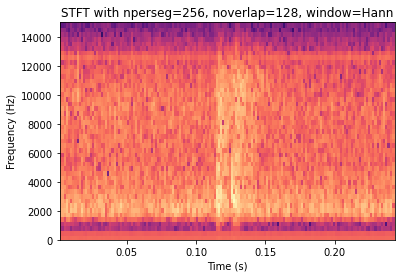

In [32]:
def gen_spectrogram(data, sr, win_length = 256, overlap=128, win='hann'):
    fig = plt.figure()
    f_bins, t_bins, Sxx = spectrogram(data, fs=sr,
                                             window=win, nperseg=win_length,
                                             noverlap=overlap, detrend=False,
                                             scaling='spectrum')
    
    Sxx[Sxx == 0] = 1e-100
    plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim([0, 15000])
    plt.title(f'STFT with nperseg={win_length}, noverlap={overlap}, window={win.capitalize()}')

data = signal_sw
sr = sr_sw
gen_spectrogram(data, sr, win_length=256)

This example shows that we can make well-informed decisions in order to construct a high-fidelity representation of an acoustic signal using a spectrogram-based approach. Firstly, we know that we want good temporal resolution (and we are not terribly concerned with frequency resolution of a broadband signal), so choosing ``npserseg=256`` yields a temporal resolution of ~2ms. Then, we select `noverlap = nperseg / 2` and a Hann window, which are good starting points in general. With these choices, we achieve a robust representation of the time-frequency characteristics of the signal of interest.

## Other Parameters

While the packages for constructing spectrograms often include numerous additional parameters to specify, we emphasize here the window size, overlap, and window type. If ever you need to explore more technical parameters, the Python modules often provide extensive and thorough documentation.

## Spectrogram Goodness

Now that we have an understanding of how to construct spectrograms, we need a way to determine the "goodness" of a representation in the sense of maximizing the amount of information contained in the original signal. A visual inspection of the above spectrograms clearly indicates that there is a noticeable (though subjective) advantage of some choices of parameters versus others. How can we quantify this in an objective way? We need a metric to compare the goodness of representations.

Here we'll define a function ``spec_rep_goodness`` to do exactly this. The motivation behind the function is to generate a spectrogram that contains the largest number of meaningful dimensions (i.e., features or information) as possible. The procedure will be as follows:

* Construct a SciPy spectrogram with clearly-defined parameter values
* Interpolate the spectrogram to circumvent errors due to frequency and time bin sizes
* Carry out a PCA and calculate the number of features required to meet some threshold for the explained variance ratio
* After carrying out a grid search of parameter values, generate the final spectrogram by maximizing the number of required features.

Our implementation of this is as follows:

In [41]:
from scipy import interpolate
from sklearn.decomposition import PCA
from itertools import count

signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

def spec_rep_goodness(x=signal_orca, sr=sr_orca, win='hann', win_length=1024, n_pca=100, th=0.95, vis=True):
    f, t, Sxx = spectrogram(x, fs=sr, window=win, nperseg=win_length,
                            noverlap=win_length//2, detrend=False,
                            scaling='spectrum')
    
    tt, ff = np.meshgrid(t, f)
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(Sxx+1e-100), kind='cubic')
    
    t_interp = np.linspace(t.min(), t.max(), 1000)
    f_interp = np.linspace(f.min(), f.max(), 1000)
    Sxx_interp = interp_fx(t_interp, f_interp)
    
    if vis:
        fog = plt.figure()
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    
    pca = PCA(n_components=n_pca)
    pca.fit(Sxx_interp)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

Now that we have our function, let's test it for a few examples by varying ``nperseg``. Given the well-established computational efficiency of using powers of 2 for the window length, we'll proceed with this in consideration.

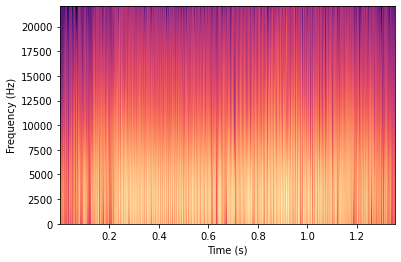

Number of Features to Exceed Threshold th=0.95: 1


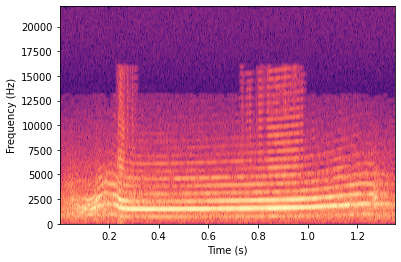

Number of Features to Exceed Threshold th=0.95: 5


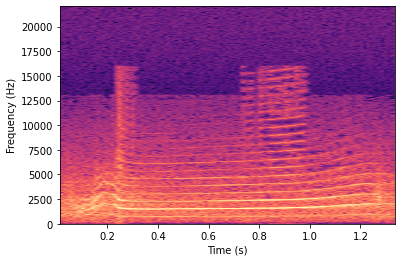

Number of Features to Exceed Threshold th=0.95: 15


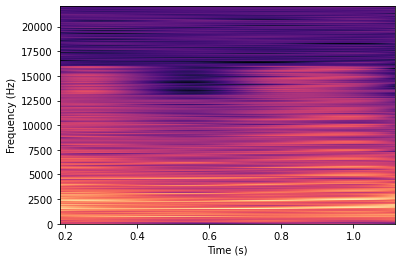

Number of Features to Exceed Threshold th=0.95: 3


In [42]:
ps = [3, 8, 10, 14]
for p in ps:
    spec_rep_goodness(win_length=2**p)

This is looking promising. Let's carry out a grid search of possible ``nperseg`` values:

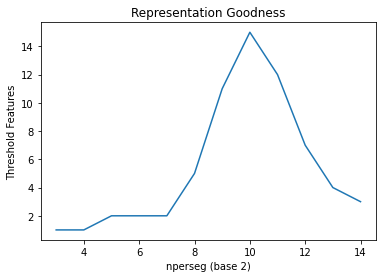

In [49]:
ps = np.arange(3, 15)
th_features = []
for p in ps:
    th_features.append(spec_rep_goodness(win_length=2**p, vis=False))
plt.figure()
plt.plot(ps, th_features)
plt.xlabel('nperseg (base 2)')
plt.ylabel('Threshold Features')
plt.title('Representation Goodness')
plt.show()

This result is fantastic and it agrees with our visual analysis of the spectrograms! Analyzing the plot, we see that for small values of ``nperseg``, we sacrifice too much frequency resolution and thus lose information. Oppositely, for large values of ``nperseg``, we sacrifice too much temporal resolution, again leading to information loss. In the intermediate range, we find a balance where the frequency and temporal resolutions have been optimized to convey as much information as possible.

The above serves as a good example of how we can use the goodness function to tune a single hyperparameter. But the hyperparamter space is highly dimensional, so realistically we would need to optimize many of the parameters simultaneously. The following provides an optimization of two parameters, and then if we wanted, we could generalize further if necessary.

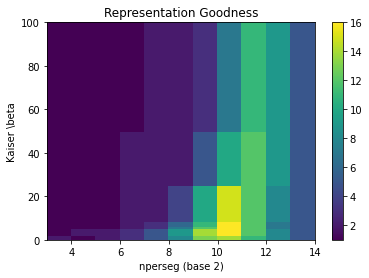

In [50]:
ps = np.arange(3, 15)
betas = [0, 2, 5, 6, 8.6, 25, 50, 100]
th_features = np.zeros((len(ps), len(betas)))

for i, p in enumerate(ps):
    for j, B in enumerate(betas):
        window_fx = kaiser(2**p, beta=B)
        th_feature = spec_rep_goodness(win_length=2**p, win=window_fx, vis=False)
        th_features[i, j] = th_feature
        
PP, BB = np.meshgrid(ps, betas)
plt.pcolormesh(PP, BB, th_features.T)
plt.colorbar()
plt.title('Representation Goodness')
plt.xlabel('nperseg (base 2)')
plt.ylabel(r'Kaiser \beta')
plt.show()

This tool can be used to ensure that we are not artificially eliminating important information (or dimensionality) by arbitrarily choosing parameter values. This is crucial since we want our neural networks to be able to extract as much meaningful information from the inputs as possible.

An alternative approach involves making use of the Von Neumann entropy, which provides insight into information contained in a matrix. Heavily used in quantum mechanics, this quantity is zero for a pure state and maximal for a maximally mixed state, so it serves somewhat as an information metric. With this in mind, let's define a similar function as above, this time making use of this metric.

In [52]:
from scipy import linalg as la
import math as m
    
def vn_entropy(arr):
    
    eigenvals = la.eigvals(arr)
    eigenvals = np.array([x for x in eigenvals.tolist() if x])

    log2_eigenvals = np.matrix(np.log2(eigenvals))
    eigenvals = np.matrix(eigenvals)

    S = -np.dot(eigenvals, log2_eigenvals.H)
    vn = np.array(np.abs(S)).flatten()
    
    return vn[0]

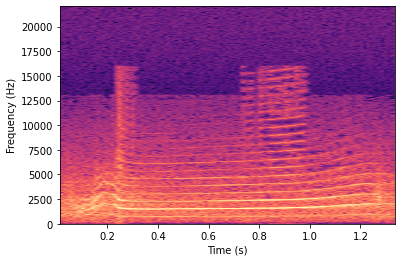

Von Neumann Entropy: 2884811.214045248


2884811.214045248

In [55]:
def spec_rep_goodness_vn(x=signal_orca, sr=sr_orca, win='hann', win_length=1024, norm='null', vis=True):
    f, t, Sxx = spectrogram(x, fs=sr, window=win, nperseg=win_length,
                            noverlap=win_length//2, detrend=False,
                            scaling='spectrum')
    
    tt, ff = np.meshgrid(t, f)
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(Sxx), kind='cubic')
    
    t_interp = np.linspace(t.min(), t.max(), 1000)
    f_interp = np.linspace(f.min(), f.max(), 1000)
    Sxx_interp = interp_fx(t_interp, f_interp)
    
    if vis:
        fog = plt.figure()
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    
    if norm == 'null':
        Sxx_norm = Sxx_interp
    elif norm == 'standardize':
        Sxx_norm = (Sxx_interp - np.mean(Sxx_interp)) / np.std(Sxx_interp)
    elif norm == 'minmax':
        Sxx_norm = (Sxx_interp - np.min(Sxx_interp)) / (np.max(Sxx_interp) - np.min(Sxx_interp))
    
    vn = vn_entropy(Sxx_norm)
    if vis:
        print(f'Von Neumann Entropy: {vn}')
    
    return vn

spec_rep_goodness_vn()

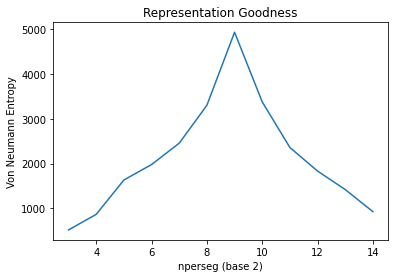

In [56]:
ps = np.arange(3, 15)
vns = []
for p in ps:
    vns.append(spec_rep_goodness_vn(win_length=2**p, norm='standardize', vis=False))
plt.figure()
plt.plot(ps, vns)
plt.xlabel('nperseg (base 2)')
plt.ylabel('Von Neumann Entropy')
plt.title('Representation Goodness')
plt.show()

Interestingly, this approach yields a similar solution as with the PCA-based method, but it's definitely worth exploring both of these ideas more extensively. For now, let's move on and continue developing our representation toolbox.

## Python Modules

For the above examples, we used SciPy's ``spectrogram`` method to construct our spectrogram. But this is not the only option. For instance, matplotlib and librosa also include methods for carrying out this type of analysis. Let's explore these options. We'll return to the orca signal as we proceed.

We'll quickly start off by constructing a spectrogram using plt.specgram. One nice thing about this method is that it includes interpolation, yielding a more attractive-looking image.

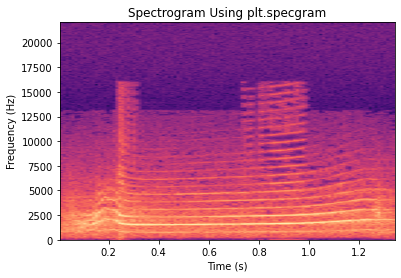

In [58]:
plt.figure()
plt.specgram(signal_orca, Fs=sr_orca, NFFT=1024, noverlap=512, cmap='magma')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram Using plt.specgram')
plt.show()

Great! Well that was easy. Let's see what happens when we use different modules:

In [60]:
def interp(spec, freqs, ts):
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(spec+1e-100), kind='cubic')
    
    ts_interp = np.linspace(t.min(), t.max(), 1000)
    freqs_interp = np.linspace(f.min(), f.max(), 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

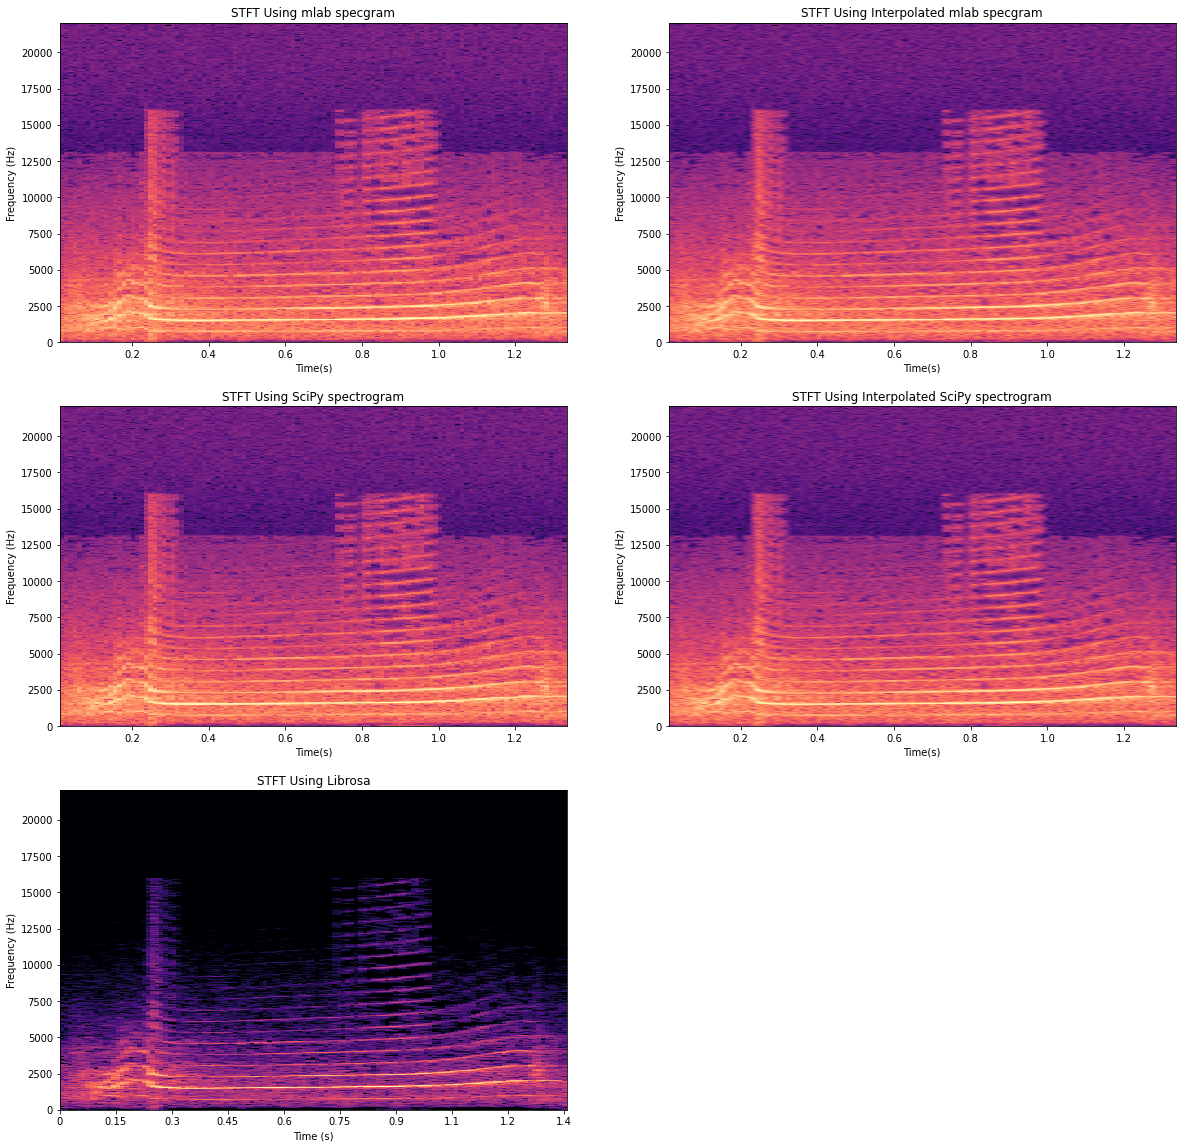

In [63]:
from matplotlib import mlab as mlab
from scipy.signal import spectrogram 
import librosa.display

fig, axs = plt.subplots(3, 2, figsize=(20,20))
spec, f, t = mlab.specgram(signal_orca, Fs=sr_orca, NFFT=1024, noverlap=512, window=mlab.window_hanning)
axs[0,0].pcolormesh(t, f, 20*np.log10(spec+1e-100), cmap='magma')
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Frequency (Hz)')
axs[0,0].set_title('STFT Using mlab specgram')

spec, f, t = interp(spec, f, t)
axs[0,1].pcolormesh(t, f, spec, cmap='magma')
axs[0,1].set_xlabel('Time(s)')
axs[0,1].set_ylabel('Frequency (Hz)')
axs[0,1].set_title('STFT Using Interpolated mlab specgram')

f, t, Sxx = spectrogram(signal_orca, fs=sr_orca, window='hann', nperseg=1024, noverlap=1024//2, detrend=False,
                            scaling='spectrum')
axs[1,0].pcolormesh(t, f, 20*np.log10(Sxx+1e-100), cmap='magma')
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Frequency (Hz)')
axs[1,0].set_title('STFT Using SciPy spectrogram')

Sxx, f, t = interp(Sxx, t, f)
axs[1,1].pcolormesh(t, f, Sxx, cmap='magma')
axs[1,1].set_xlabel('Time(s)')
axs[1,1].set_ylabel('Frequency (Hz)')
axs[1,1].set_title('STFT Using Interpolated SciPy spectrogram')


D = librosa.amplitude_to_db(np.abs(librosa.stft(signal_orca)), ref=np.max)
plt.subplot(3, 2, 5)
librosa.display.specshow(D, y_axis='linear', x_axis='time', cmap='magma', sr=sr_orca)
plt.title('STFT Using Librosa')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

fig.delaxes(axs[2][1])

plt.show()

In general, the different packages all produce the expected results, with minor differences (note that the apperance of the librosa spectrogram can simply be explained by the default threshold used converting to the dB scale with the ``amplitude_to_db`` method). With the being said, SciPy or mlab might be advantageous given their enhanced lower-leverl flexibility relative to librosa.

Before investigating other possible representations of acoustic signals, let's take a look at a few other methods for constructing spectrogram's, using Tim Saingburg's [blog](https://timsainburg.com/category/signal-processing.html) as a reference.

## Sainburg's Approach to Constructing Spectrograms

While we've already explored a number of options for generating spectrogram representations, we'll discuss a few final methods. We'll begin with some necessary imports:

In [64]:
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

Next, we'll define a few methods to clean the signal.

In [65]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

With these tools prepared, we're now ready to construct our spectrograms. In his blog, Sainburg adopts a super low-level approach, that we include here for completeness. We'll glance over his code with limited commentary.

In [66]:
def overlap(X, window_size=1024, window_step=512):
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))
    
    valid = len(X) - window_size
    nw = valid // window_step
    out = np.ndarray((nw, window_size), dtype=X.dtype)
    
    for i in np.arange(nw):
        start = i * window_step
        stop = start + window_size
        out[i] = X[start:stop]
        
    return out

def stft(X, fftsize=1024, step=512, mean_normalize=True, 
         real=False, compute_onesided=True):
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
        
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()
        
    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d, log=True, thresh=5, fft_size=1024, step_size=512):

    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()
        specgram = np.log10(specgram)
        specgram[
            specgram < -thresh
        ] = -thresh
    else:
        specgram[
            specgram < thresh
        ] = thresh

    return specgram

In [67]:
fft_size = 1024
step_size = fft_size // 2
spec_thresh = 4
lowcut = 500
highcut = 15000

In [69]:
data = butter_bandpass_filter(signal_orca, lowcut, highcut, sr_orca, order=1)

In [70]:
wav_spectrogram = pretty_spectrogram(
    data.astype("float64"),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh,
)

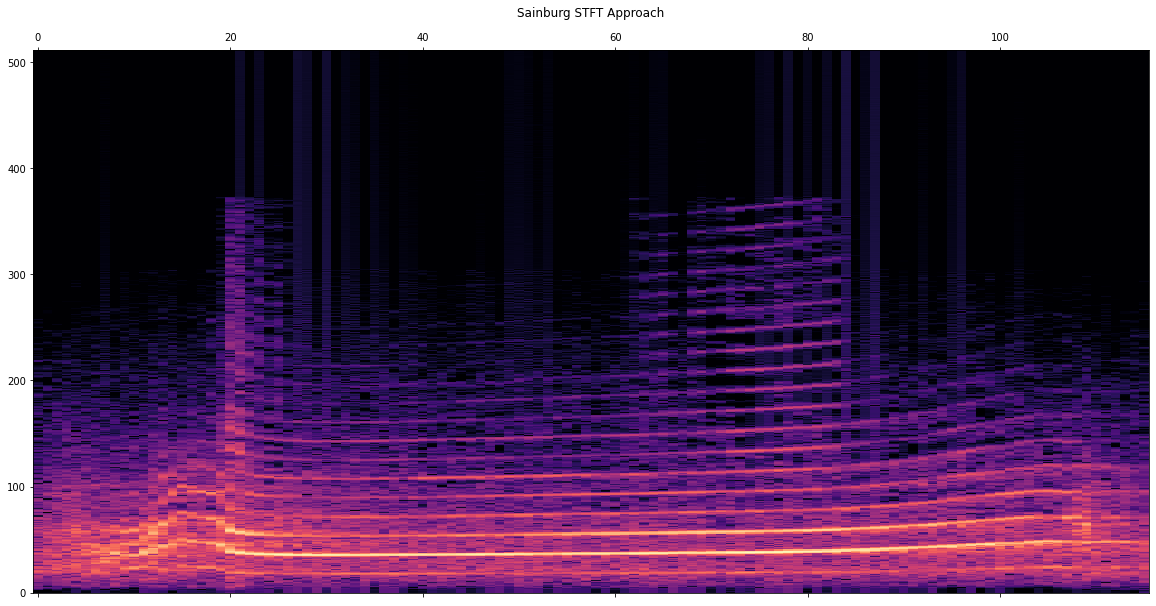

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
cax = ax.matshow(
    np.transpose(wav_spectrogram),
    interpolation="nearest",
    aspect="auto",
    cmap='magma',
    origin="lower",
)
plt.title('Sainburg STFT Approach')
plt.show()

The final step in the Sainburg pipeline involves converting the spectrogram to a melspectrogram, which simply involves a transformation to the mel frequency scale, defined as

$$\text{mel} = 2595*\log10(1+\text{Hz}/700)$$

Again, we provide the code from Sainburg's blog, but for our purposes, we won't dive too deeply into this low-level technique.

In [72]:
def make_mel(spectrogram, mel_filter, shorten_factor=1):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(
        mel_spec.astype("float32"), [1, 1.0 / shorten_factor]
    ).astype("float16")
    mel_spec = mel_spec[:, 1:-1]
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    mel_spec = mel_spec + spec_thresh
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(
        uncompressed_spec.astype("float32"), [1, shorten_factor]
    ).astype("float16")
    uncompressed_spec = uncompressed_spec - 4
    return uncompressed_spec

def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)


def mel2hz(mel):
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def create_mel_filter(
    fft_size, n_freq_components=64, start_freq=300, end_freq=8000, samplerate=44100
):
    mel_inversion_filter = get_filterbanks(
        nfilt=n_freq_components,
        nfft=fft_size,
        samplerate=samplerate,
        lowfreq=start_freq,
        highfreq=end_freq,
    )

    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

In [73]:
n_mel_freq_components = 64
shorten_factor = 1
start_freq = 300
end_freq = 8000

In [74]:
mel_filter, mel_inversion_filter = create_mel_filter(
    fft_size=fft_size,
    n_freq_components=n_mel_freq_components,
    start_freq=start_freq,
    end_freq=end_freq,
)

In [75]:
mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor=shorten_factor)

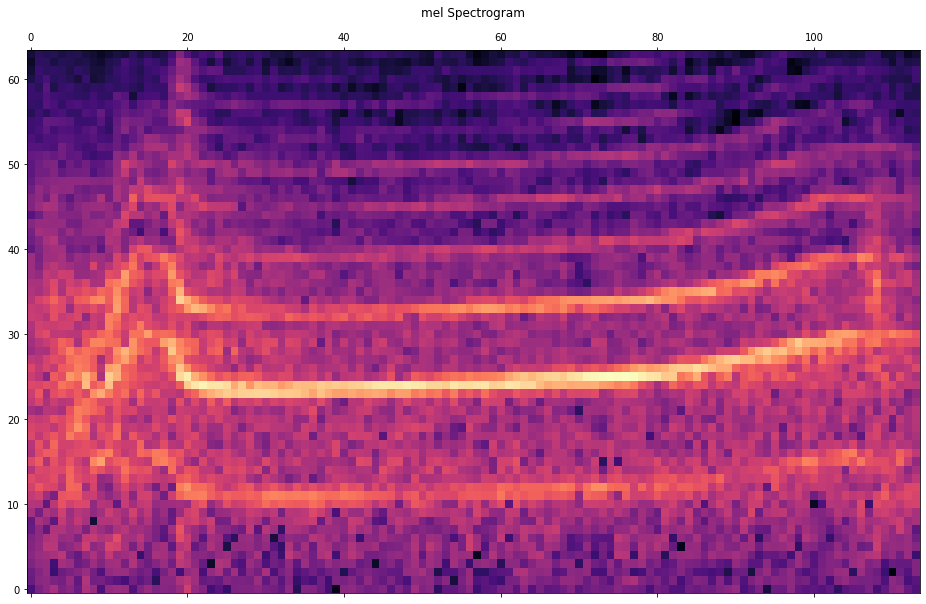

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
cax = ax.matshow(
    mel_spec.astype("float32"),
    interpolation="nearest",
    aspect="auto",
    cmap='magma',
    origin="lower",
)
plt.title("mel Spectrogram")
plt.show()

Before moving on, we'll take a quick look at [this paper](https://arxiv.org/pdf/1709.01922.pdf) to compare audio signal preprocessing methods. The key takeaway is that although there are numerous commonly used input image preprocessing techniques, the vast majority are reduntant with the exception of logarithmic magnitude compression. Let's dive a little deeper.

Essentially, the goal of the paper is to address and optimize possible audio preprocessing strategies for deep convolutional neural networks (CNNs). Melspectrograms (such as that shown directly above) have conventionally been preffered over STFT approaches from an efficient-yet-effective perspective, but logarithmic compression of a time-frequency representation is an alternatively popular method.

Traditionally, STFT and melspectrogram have been the most popular representations, with melspectrograms providing an efficient and perceptually relevant (based on the mechanics of human hearing) representation and spectrograms offering a more faithful representaion of the original signal, enabling neural networks to extract features optimized for a given task. Also, melspectrograms have proved advantageous when using small datasets.

Ultimately, the authors experimented with a number of preprocessing techniques (time-frequency representation, frequency weighting, and magnitude scaling), concluding that the only factor that significantly impacted performance was logarithmic (decibel) magnitude scaling. This is demonstrated in the following plot.

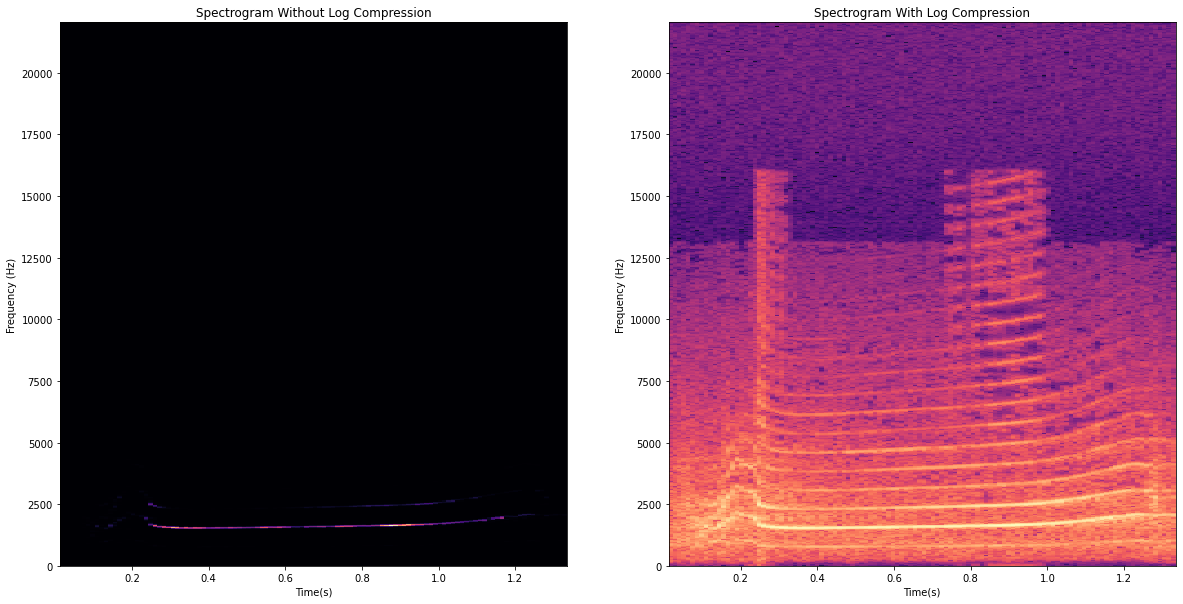

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
spec, f, t = mlab.specgram(signal_orca, Fs=sr_orca, NFFT=1024, noverlap=512, window=mlab.window_hanning)
axs[0].pcolormesh(t, f, spec , cmap='magma')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('Spectrogram Without Log Compression')

axs[1].pcolormesh(t, f, 20*np.log10(spec+1e-100), cmap='magma')
axs[1].set_xlabel('Time(s)')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_title('Spectrogram With Log Compression')
plt.show()

## Time-Frequency Reassigned Spectrogram

In our last experiment of our spectrogram exploration, let's take a look at an alternative to the convential STFT approach. We'll construct a time-frequency reassigned spectrogram, which has been shown to provide a sharper representation of the signal. Additional information can be found [here](https://arxiv.org/pdf/0903.3080.pdf).

As we've discussed earlier, the spectrogram-based representation of acoustic signals unfortunately demands a tradeoff between spectral and temporal resolution. The time-frequency reassigned (TFR) spectrogram provides a means to achieve sharper resolutions. Here, we will explore this approach to acoustic signal representation.

Unlike the conventional STFT approach, which yields a blurred representation, the TFR method maps data
to time-frequency coordinates that are nearer to the true region of support of the analyzed signal, yielding a sharper representation of the original signal.

For our first exploration of reassigned spectrograms, we'll make use of the ``reassigned_spectrogram`` method in librosa.

In [83]:
from librosa.core import reassigned_spectrogram as librosa_tfr_spec

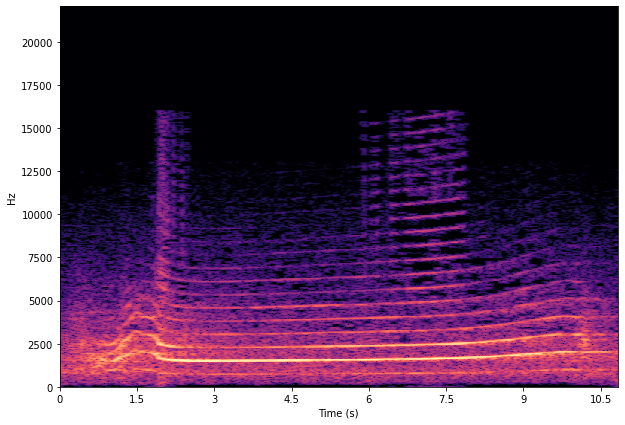

In [85]:
freqs, times, tfr_Sxx = librosa_tfr_spec(y=signal_orca, sr=sr_orca, n_fft=1024, hop_length=64)
tfr_Sxx_db = librosa.power_to_db(tfr_Sxx, amin=1e-2)
fig = plt.figure(figsize=(10,7))
librosa.display.specshow(tfr_Sxx_db, x_axis="s", y_axis="linear", sr=sr_orca, hop_length=512, cmap='magma')
plt.show()

We see a moderate improvement in resolution versus the original STFT approach, but let's look at some other modules. Let's use the ``reassigned_spectrogram`` method contained in the tfr package. 

output_frame_count 467


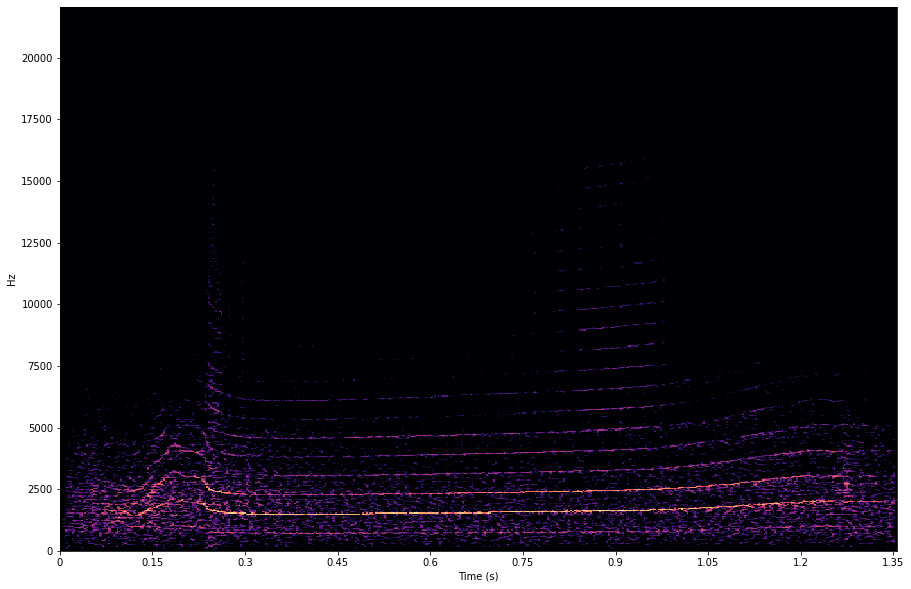

In [87]:
import tfr
import warnings
warnings.simplefilter('ignore', FutureWarning)

signal_frames = tfr.SignalFrames(path_name, frame_size=1024, hop_size=128)
x_spectrogram = tfr.reassigned_spectrogram(signal_frames)
fig = plt.figure(figsize=(15,10))
librosa.display.specshow(x_spectrogram.T, x_axis="s", y_axis="linear", sr=sr_orca, hop_length=128, cmap='magma')
plt.show()

This looks like we might be on the right path to getting improved time-frequency resolution. Finally, we'll show the results using the libtfr package. This looks like we might be on the right path to getting improved time-frequency resolution. Finally, we'll show the results using the libtfr package. We'll have to explore the installation of this package more thoroughly, so for now we'll just show a sample image output that we've saved.

![title](TFR-Spectrogram.png)

As we can see, the TFR spectogram generated using the libtfr module provides enhanced resolution that might yield a representation that captures the information contained in the original acoustic signal with a higher degree of fidelity. With this in mind, it would be ideal to further explore this approach, but we'll have to look into a better method for installing the libtfr package, since now the procedure for doing so is somewhat convoluted.

Before concluding our discussion on spectrogram representations, we'll provide a complete pipeline.

## A Complete Pipeline

After exploring numerous options for constructing spectrograms, we are finally ready to go through the complete pipeline. First, we begin by loading the acoustic waveform of interest.

In [103]:
data_orca, sr_orca = sf.read(path_name)

Next, we'll define a few methods that will help us optimize our spectrogram-based acoustic representation. The procedure is as follows:

* Define a method to construct spectrograms and return time bins, frequency bins, and the spectrogram using librosa's ``reassigned_spectrogram``
* Interpolate the spectogram
* Compute the goodness (using the PCA-motivated approach) for a given spectrogram
* Carry out a parameter grid search to maximize the goodness
* Plot the final spectrogram, removing unnecessary add-ons such as xlabels, ylabels, tick marks, colorbars, etc.

Ultimately, this process culminates in a spectrogram image that would serve as a basis for constructing a dataset of spectrogram images for a machine learning (ML) application.

We'll move forward with constructing a spectrogram:

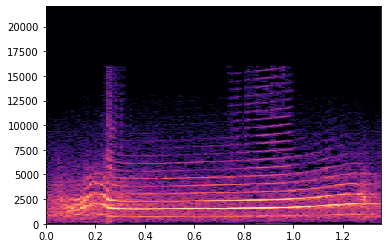

In [104]:
def construct_spectrogram(signal, sr, nfft=1024, hoplength=None, win=scipy.signal.hanning, db_th=1e-2):
    if hoplength is None:
        hoplength = nfft//2

    _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
    spec_db = librosa.power_to_db(spec, amin=db_th)
    f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
    t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
    return t_bins,f_bins, spec_db

t, f, Sxx = construct_spectrogram(data, sample_rate)
plt.pcolormesh(t, f, Sxx, cmap='magma')
plt.show()

Great! Next, we'll smoothen the spectrogram by carrying out an interpolation using cubic splines.

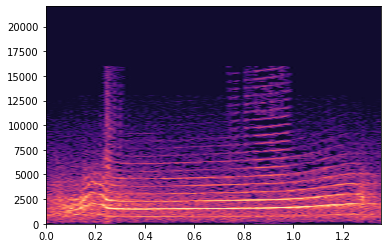

In [105]:
def interp_spectrogram(spec, t, f):
    interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
    
    ts_interp = np.linspace(np.min(t), np.max(t), 1000)
    freqs_interp = np.linspace(np.min(f), np.max(f), 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

spec_interp, freqs_interp, ts_interp = interp_spectrogram(Sxx, t, f)
spec_interp.shape, freqs_interp.shape, ts_interp.shape
plt.pcolormesh(ts_interp, freqs_interp, spec_interp, cmap='magma')
plt.show()

In order to quantify how "good" are representation is, we'll look at how many PCA features are required to meet a threshold for the explained variance ratio. This serves as a proxy for the amount of meaningful information contained in the representation.

In [106]:
def compute_goodness(spec_interp, n_pca=100, th=0.95):
    pca = PCA(n_components=n_pca)
    pca.fit(spec_interp)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    return feature_i+1

compute_goodness(spec_interp)

14

Now that we've computed the goodness for a default choice of parameters, let's loop through a grid of parameter values in order to optimize the goodness of the representation. This is achived using the ``optimize_spectrogram`` method:

In [107]:
def optimize_spectrogram(signal, sr, p_nffts=np.arange(3, 15)):
    
    metrics = []
    for p in p_nffts:
        t, f, Sxx = construct_spectrogram(signal, sr, nfft=2**p)
        Sxx_interp, f_interp, t_interp = interp_spectrogram(Sxx, t, f)
        goodness = compute_goodness(Sxx_interp)
        metrics.append(goodness)
    
    idx = metrics.index(np.max(metrics))
    return p_nffts[idx]

    
opt_p = optimize_spectrogram(data, sample_rate)
print(f'Optimal Window Size: nfft={2**opt_p}')

Optimal Window Size: nfft=1024


Finally, we can plot the optimized spectrogram representation. For an actual ML application, we would save a collection of spectrograms with appropriate labels for the given task of interest. Also, note that when constructing a dataset comprised of an ensemble of spectrograms, it is crucial to normalize the colorbar using the ``vmin`` and ``vmax`` arguments.

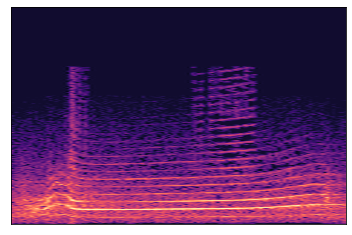

In [108]:
def plot_spectrogram(signal, sr, opt_nnft=1024, amin=1e-2, norm=True):
    t, f, Sxx = construct_spectrogram(signal, sr, nfft=opt_nnft, db_th=amin)
    Sxx_interp, f_interp, t_interp = interp_spectrogram(Sxx, t, f)
    
    if norm:
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma', vmin=-24, vmax=21)
    else:
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')    
    plt.xticks([])
    plt.yticks([])

plot_spectrogram(data, sample_rate)

We'll reiterate the importance of the colorbar normalization with the following plot:

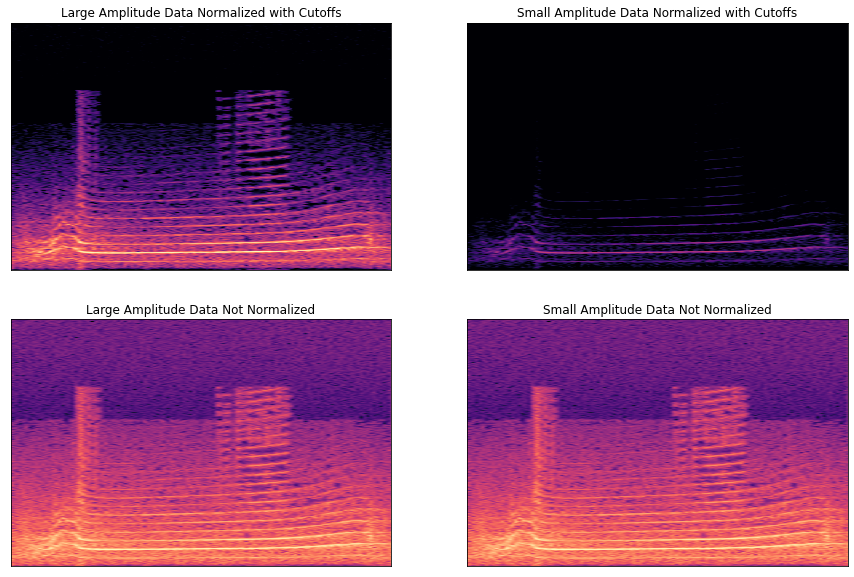

In [109]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plot_spectrogram(data, sample_rate, amin=1e-10)
plt.title('Large Amplitude Data Normalized with Cutoffs')
plt.subplot(2, 2, 2)
plot_spectrogram(0.01*data, sample_rate, amin=1e-10)
plt.title('Small Amplitude Data Normalized with Cutoffs')
plt.subplot(2, 2, 3)
plot_spectrogram(data, sample_rate, amin=1e-10, norm=False)
plt.title('Large Amplitude Data Not Normalized')
plt.subplot(2, 2, 4)
plot_spectrogram(0.01*data, sample_rate, amin=1e-10, norm=False)
plt.title('Small Amplitude Data Not Normalized')
plt.show()

As shown in the above plots, it is absolutely necessary to ensure that spectrograms are properly normalized when constructing a dataset containing different desired classes.

This concludes our exploration of spectrogram representations. Let's continue with some other acoustic signal representations.

## Addendum: Using the libtfr Package

While the installation procedure for the libtfr package is rather complicated and would benefit from an update, here we demonstrate the advantages of using the time-frequency reassigned approach implemented in this module. We start off by importing libtfr:

In [110]:
import libtfr

For the first application, let's take a look at the orca call.

In [111]:
data_orca, sr_orca = sf.read(path_name)

In [112]:
nfft = 1024
Np = nfft
shift = nfft/16
K = 6
tm = 6.0
flock = 0.01
tlock = 5

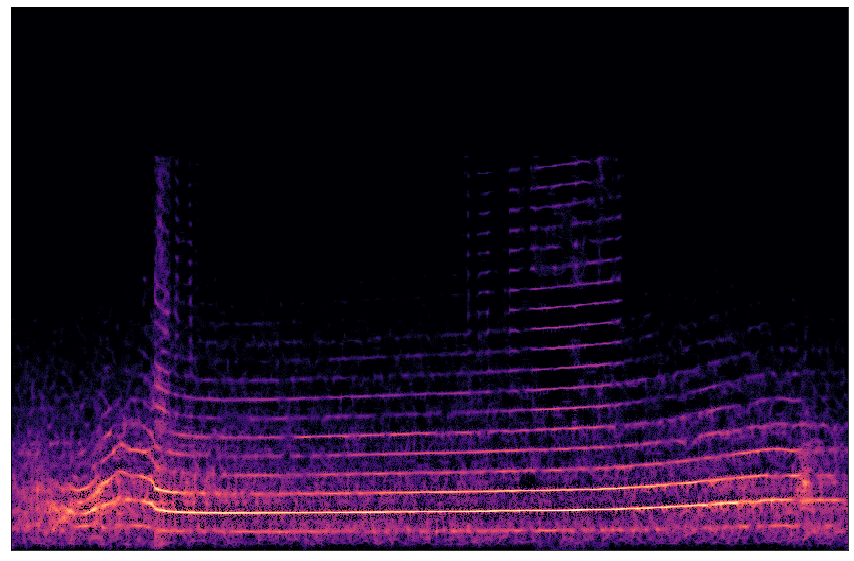

In [113]:
S = np.abs(libtfr.tfr_spec(s=data_orca, N=nfft, step=shift, Np=Np, K=K, tm=tm, flock=flock, tlock=tlock))
S = librosa.amplitude_to_db(S, ref=np.max, top_db = 140)
fig, ax = plt.subplots(figsize=(15,10))
librosa.display.specshow(S, y_axis='linear', cmap='magma')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()

Clearly, the above spectrogram reveals an incredibly high degree of resolution that cannot be achieved using the STFT approach. But how does this approach work with a transient signal? To address this question, let's return to the sperm whale click.

In [114]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[24000:44000]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))
T_sw = 1 / sr_sw

In [115]:
nfft = 256
Np = nfft
shift = nfft/2
K = 6
tm = 6.0
flock = 0.01
tlock = 5

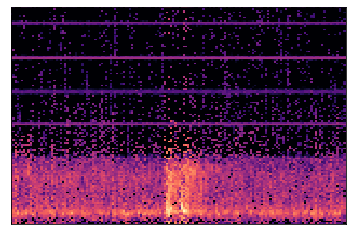

In [119]:
S = np.abs(libtfr.tfr_spec(s=signal_sw, N=nfft, step=shift, Np=Np, K=K, tm=tm, flock=flock, tlock=tlock))
S = librosa.amplitude_to_db(S, ref=np.max, top_db = 140)
fig, ax = plt.subplots(figsize=(6,4))
librosa.display.specshow(S, y_axis='linear', cmap='magma')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()